In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
from IPython.display import Image

### Part A.a

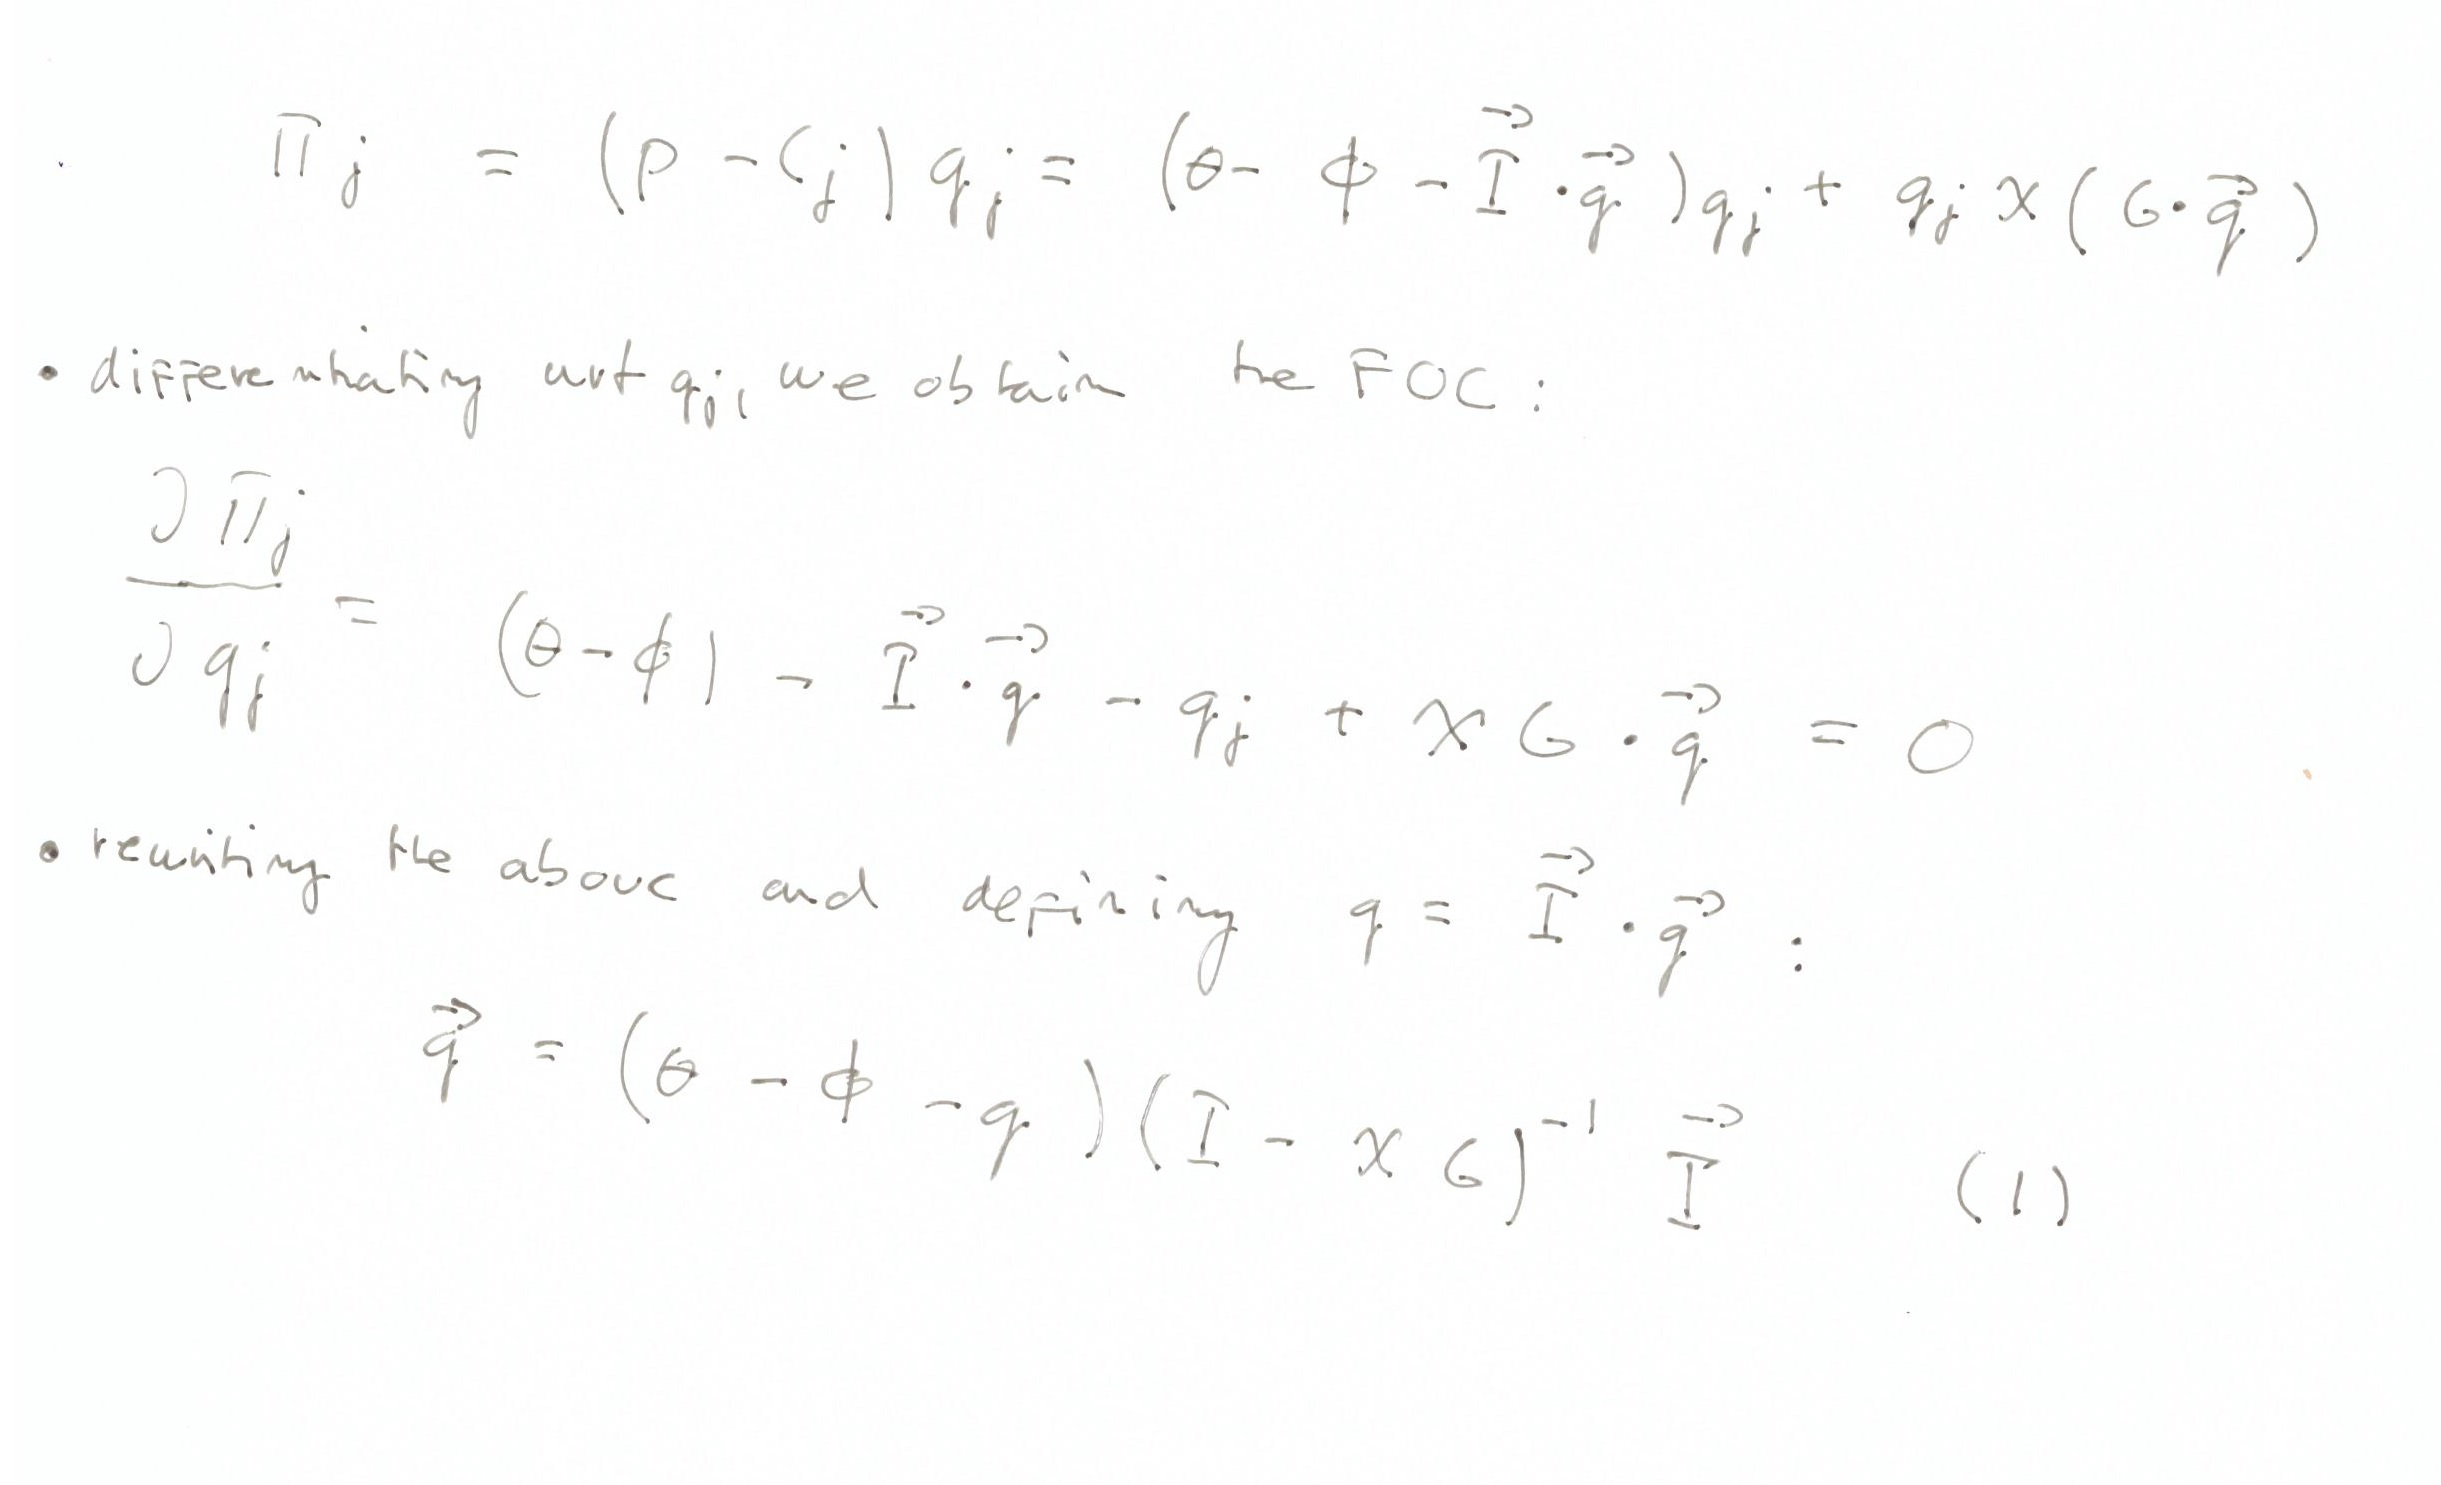

In [4]:
Image(filename=r'C:\Users\Jakub\Desktop\compm1.1.jpg')

### Part A.b

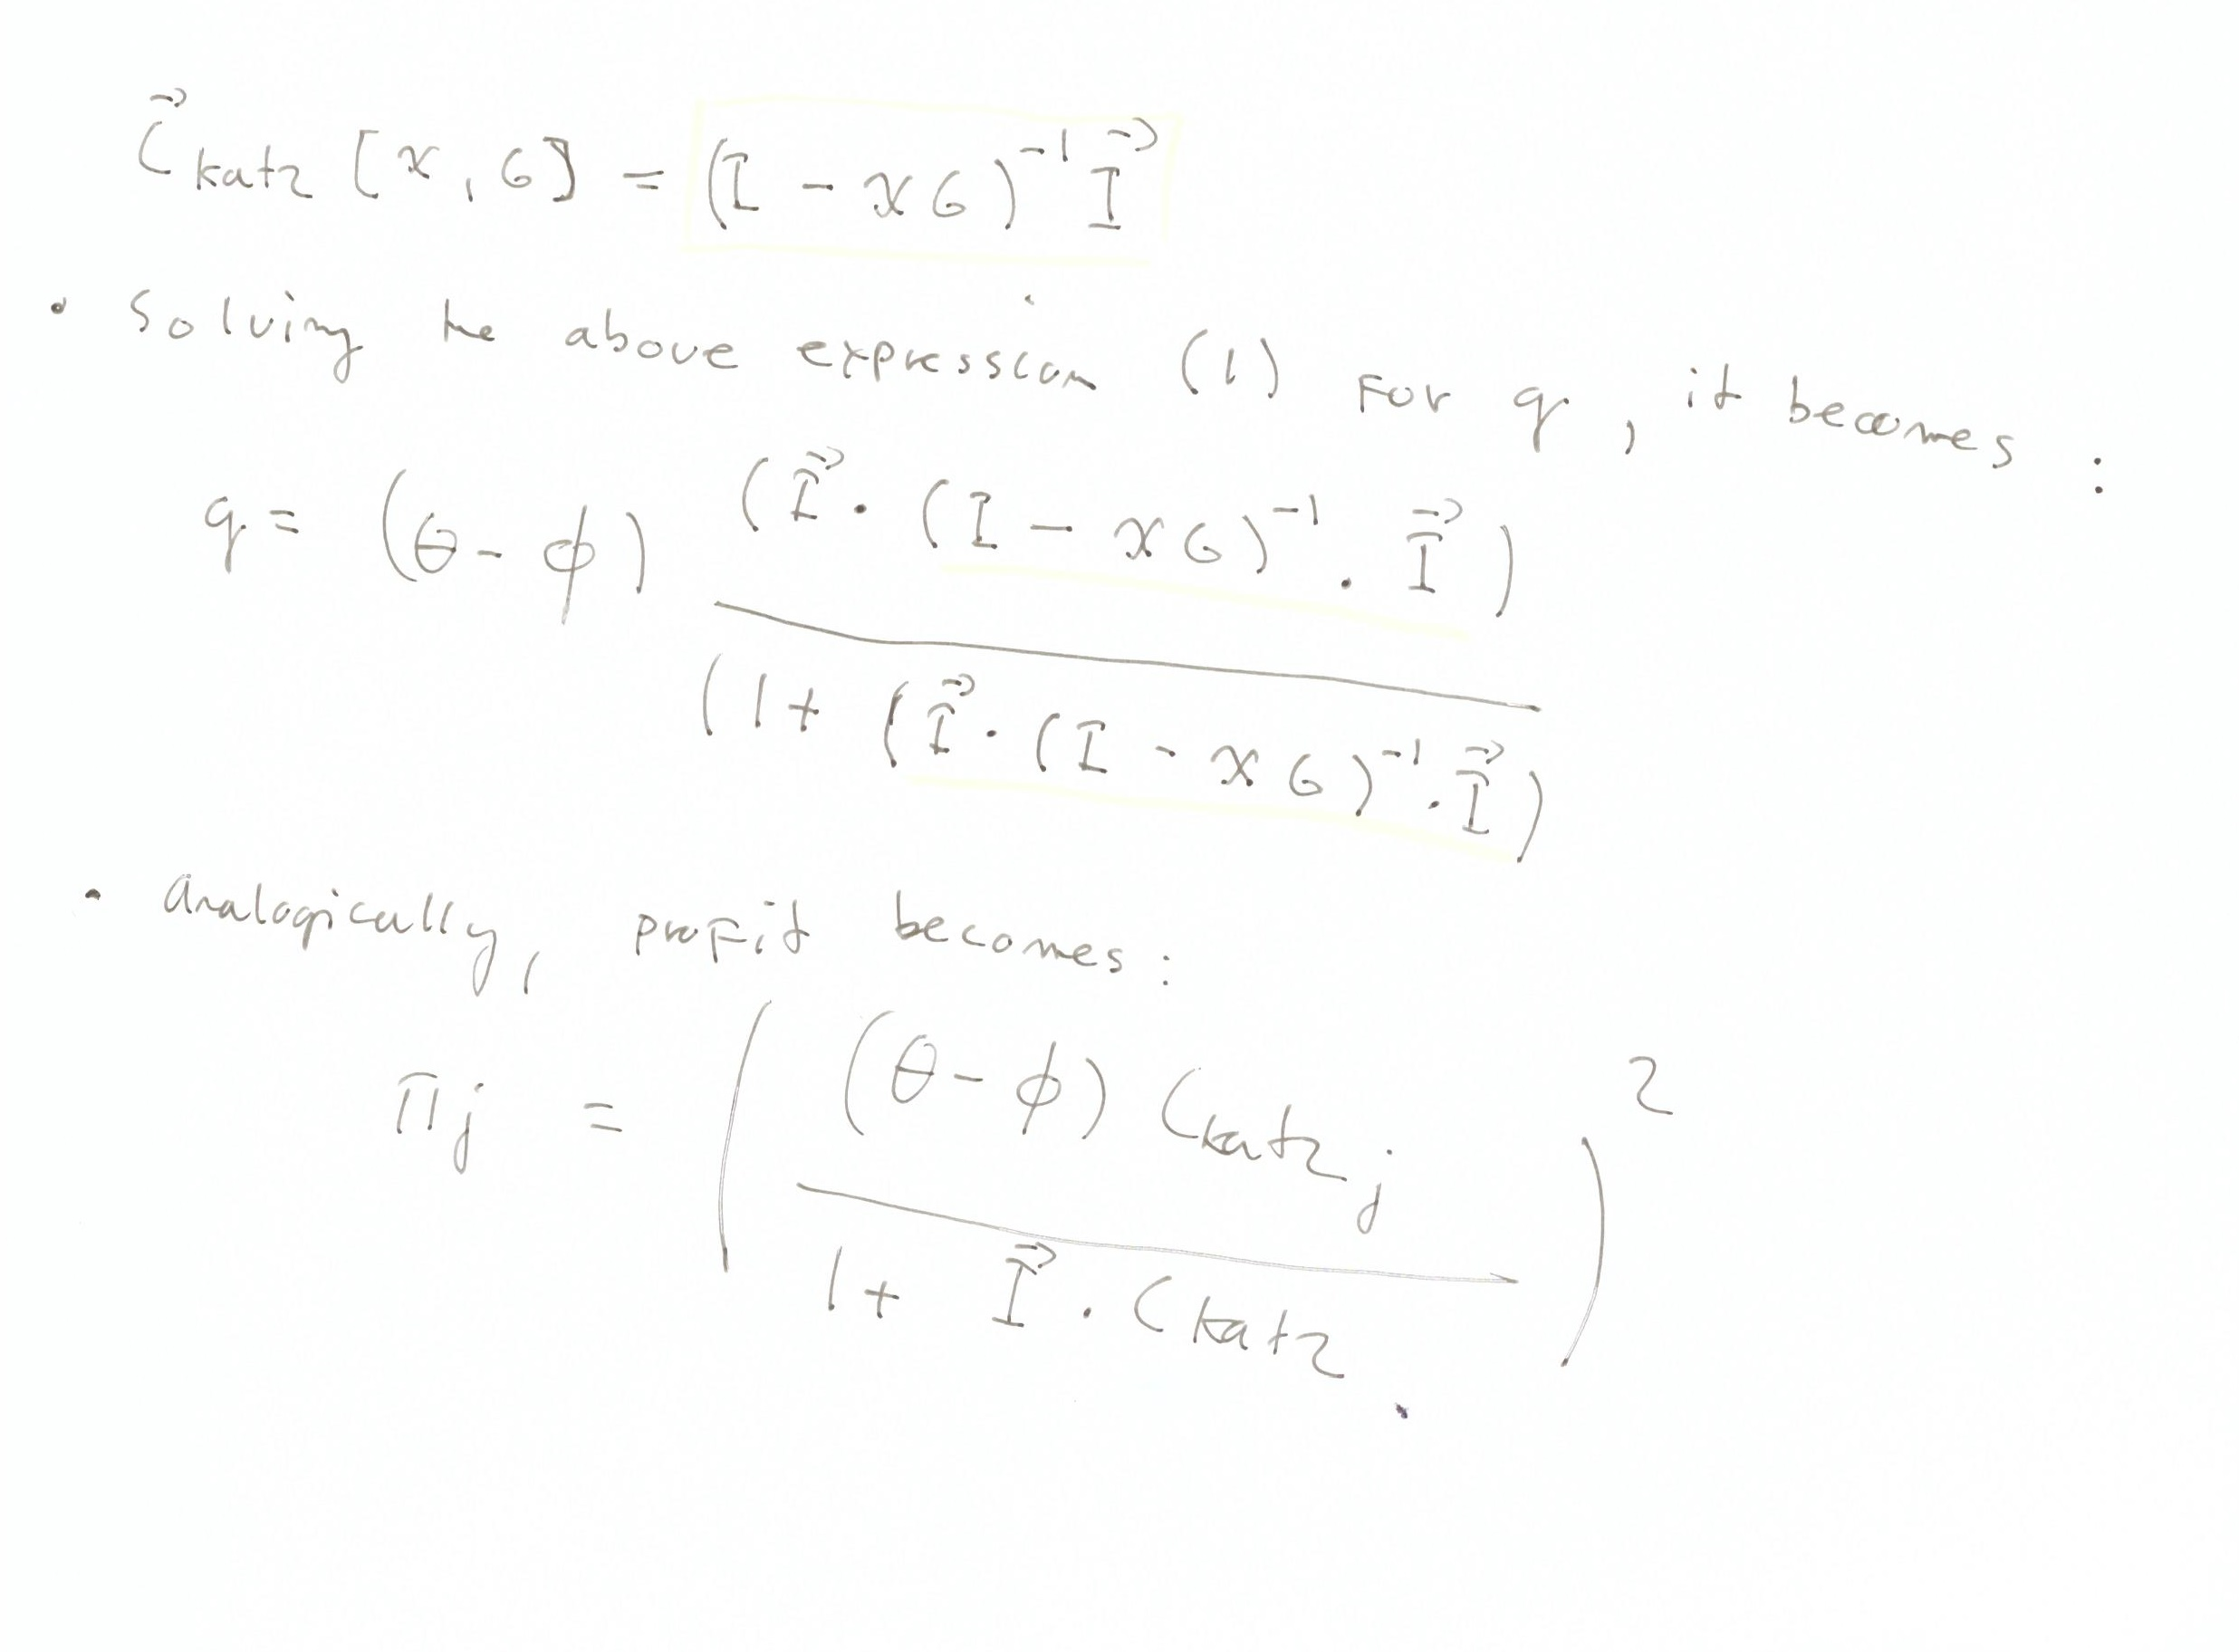

In [5]:
Image(filename=r'C:\Users\Jakub\Desktop\compm1.2.jpg')

So the equilibrium profit of bank j:
- is proportional to square of it Katz Centrality. The better a bank is connected to the lending market, the lower (marginal) cost of loan is
- decreases with an increase of Katz Centralities of other banks (the denominator). This can be interpreted as banks comparing for a largely fixed pool of clients - their relative marginal costs are important too, since they can undercut offerings of other banks and gain a dominant position on the market.

### Part A.c

The function rmatrix(prob, n_) returns an instance of the (generally non-symmetric) required matrix:

In [11]:
def rmatrix(prob, n_):
    gr1 = nx.fast_gnp_random_graph(n=n_,p=prob, directed = True) # initialize with n and m
    edge_colors = []
    for (u, v) in gr1.edges():
        helper = np.random.rand()
        if helper>=prob:
            random_weight = 1
        else:
            random_weight = 0
        gr1.edges[u,v]['weight'] = random_weight
    old_adj = nx.adjacency_matrix(gr1)
    adj = nx.adjacency_matrix(gr1)
    return adj.todense()

### Part A.d

For reasons that will become clear later on in the notebook, I will refer to te definition of Katz Centrality in this form, using Alpha rather than chi

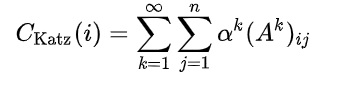

In [12]:
Image(filename=r'C:\Users\Jakub\Desktop\compmalpha.jpg')

We proceed to generate instance of the matrix from b  (adj1) and use eq_profits to calculate equilibrium profits of the banks as a function of alpha

In [13]:
adj1 = rmatrix(0.3,10)

In [17]:
def katz_centrality_(adj_matrix, alpha = 0.45):
    size = adj_matrix.shape[0]
    I = np.identity(size)
    inside = np.linalg.inv(I- alpha*np.transpose(adj_matrix))
    centralities1 = list(np.asarray(np.dot((inside-I),np.ones(size)))[0])
    centralities_dict = {i:centralities1[i] for i in range(len(centralities1))}
    #return centralities_dict
    return centralities1

def eq_profits(adj_matrix, thetadiff, katz_alpha):
    centralities1 = katz_centrality_(adj_matrix, katz_alpha)
    total = np.sum(centralities1)
    profits = [((thetadiff*i)/(1+total))**2 for i in centralities1]
    return profits # [ i/np.sum(profits) for i in profits]

In [18]:
list_ = []
for i in range(50):
    alpha = i/50
    pr = eq_profits(adj1, 15, alpha)
    pr.append(alpha)
    list_.append(pr)
    
    bankslist = ['bank'+str(i+1) for i in range(10)]
    bankslist.append('alpha')
df_alpha = pd.DataFrame(list_,columns= bankslist)

We see that modifying the attenuation factor gives more/less market share to different banks. Greater alpha gives more profits to banks connected by many step paths to competitors and vice versa. At Alpha =1, our bank network turned into a duopoly:

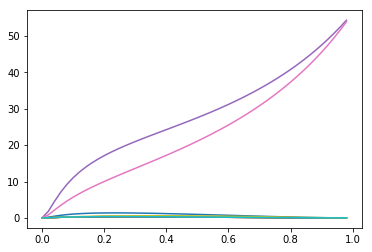

In [19]:
plt.plot(df_alpha.alpha, df_alpha.bank1)
plt.plot(df_alpha.alpha, df_alpha.bank2)
plt.plot(df_alpha.alpha, df_alpha.bank3)
plt.plot(df_alpha.alpha, df_alpha.bank4)
plt.plot(df_alpha.alpha, df_alpha.bank5)
plt.plot(df_alpha.alpha, df_alpha.bank6)
plt.plot(df_alpha.alpha, df_alpha.bank7)
plt.plot(df_alpha.alpha, df_alpha.bank8)
plt.plot(df_alpha.alpha, df_alpha.bank9)
plt.plot(df_alpha.alpha, df_alpha.bank10)
plt.show()

 What is not clear from the above is that the two best connected banks are splitting the market evenly (they happen to have same Katz Centralities) and increasing Alpha to 1 completely decimates maarket shares of all the othes banks:

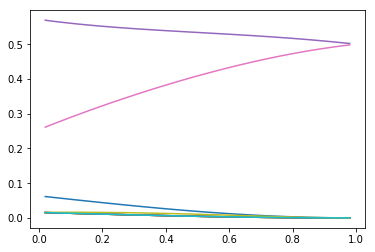

In [23]:
Image(filename=r'C:\Users\Jakub\Desktop\computational methods\market shares.png')

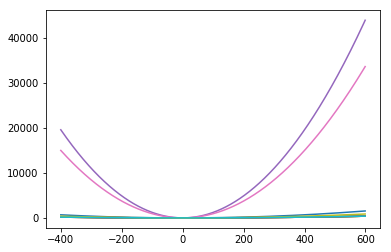

In [24]:
list__ = []
for i in range(1000):
    thetadiff= i-400
    pr = eq_profits(adj1, thetadiff, 0.5)
    pr.append(thetadiff)
    list__.append(pr)
    
    bankslist = ['bank'+str(i+1) for i in range(10)]
    bankslist.append('thetadiff')
df_thetadiff = pd.DataFrame(list__,columns= bankslist)

plt.plot(df_thetadiff.thetadiff, df_thetadiff.bank1)
plt.plot(df_thetadiff.thetadiff, df_thetadiff.bank2)
plt.plot(df_thetadiff.thetadiff, df_thetadiff.bank3)
plt.plot(df_thetadiff.thetadiff, df_thetadiff.bank4)
plt.plot(df_thetadiff.thetadiff, df_thetadiff.bank5)
plt.plot(df_thetadiff.thetadiff, df_thetadiff.bank6)
plt.plot(df_thetadiff.thetadiff, df_thetadiff.bank7)
plt.plot(df_thetadiff.thetadiff, df_thetadiff.bank8)
plt.plot(df_thetadiff.thetadiff, df_thetadiff.bank9)
plt.plot(df_thetadiff.thetadiff, df_thetadiff.bank10)
plt.show()

We see here that profits are, as expected, a quadratic function of the difference between thetas (thetadiff)

Below, Katz centrality as fucntion of Alpha becomes negative slightly before Alpha = 0.65 (reeciprocal of the absolute value of the largest eigenvalue of our adjacency matrix). Some publications (Junker, 2008) quote this value as a cutoff for where Katz Centrality id defined. I didn't restrict the range of Alpha to that value, however, since profits are a square of alpha and thus can't be nonnegative, avoiding nonsensical output.

This also highlights the relative robustness of the model - increasing Alpha beyond that critical value doesn't change our interpretations - taking the dupoly story from above as an example, the convergence of market shares continues beyond Alpha = 0.65.

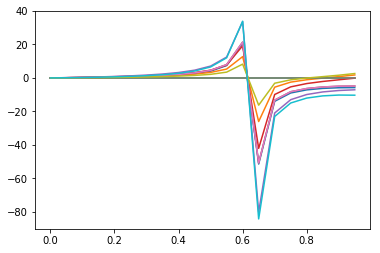

In [35]:

Image(filename=r'C:\Users\Jakub\Desktop\computational methods/alpha katz.png')

### Part B

function rewire(matrix, prob_alpha) does the operation decsribed in the setup of part B, using helper functions which_node, max_node and katz_centrality. iterator(mat, times) then takes our adjacency matrix and repeats the rewiring operation.

In [36]:
def katz_centrality(adj_matrix, alpha = 0.45):
    size = adj_matrix.shape[0]
    I = np.identity(size)
    inside = np.linalg.inv(I- alpha*np.transpose(adj_matrix))
    centralities = np.dot((inside-I),np.ones(size))
    centralities_ = list(np.asarray(centralities)[0])
    centralities_dict = {i:centralities_[i] for i in range(len(centralities_))}
    return centralities_dict



def which_node(some_dict):
    the_key = 0
    for key, value in some_dict.items():
        if value == min(some_dict.values()):
            the_key = key
    return the_key
def max_node(some_dict):
    the_key = 0
    for key, value in some_dict.items():
        if value == max(some_dict.values()):
            the_key = key
    return the_key
    
def rewire(matrix, prob_alpha):
    mat = copy.copy(matrix)
    centralities_ = katz_centrality(mat)
    lowest_katz = which_node(centralities_)
    l = lowest_katz
    banks_not_connected = []
    rows = mat.shape[0]
    cols = mat.shape[1]
    for x in range(0, rows):
        if mat[l,x] == 0 and mat[x,l] == 0:
                banks_not_connected.append(x)
    banks_connected = [i for i in range(10) if i not in banks_not_connected]
    # option a
    eligible_1 = {k: v for k, v in centralities_.items() if k in banks_not_connected}
    connecting_node_1 = max_node(eligible_1)
    # option b
    eligible_2 = {k: v for k, v in centralities_.items() if k not in banks_not_connected}
    connecting_node_2 = which_node(eligible_2)
    
    helper = np.random.rand()
    dir_helper = np.random.rand()
    if helper<= prob_alpha:
        # print('option a')
        # do a
        if dir_helper<0.5:
            mat[l, connecting_node_1] = 1
        else:
            mat[connecting_node_1, l] = 1
    else:
        # print('option b')
        # do b
        if dir_helper<0.5:
            mat[l, connecting_node_2] = 0
        else:
            mat[connecting_node_2, l] = 0
    return mat
recorder = []
def iterator(mat, times):
    ct = 1
    init = mat
    while ct<= times:
        now = rewire(init, 0.4)
        recorder.append(init)
        init = now
        ct+=1
iterator(adj1,50)

In [38]:
list_1= []
for i in range(len(recorder)):
    pr = eq_profits(recorder[i], 15, 0.5)
    list_1.append(pr)
    bankslist = ['bank'+str(i+1) for i in range(10)]
df_evolved_profits = pd.DataFrame(list_1,columns= bankslist)

 Part B - b)
The most profitable bank's profits decrease over time (orange), as this rewiring process redistributes links that are important for lowering marginal costs of banks. In economics terms, this means that the competition increased through more similar marginal cost and market shares seem to converge. So the position of the most powerful bank weakens and we can expect close to leveled playing field as we iterate further.

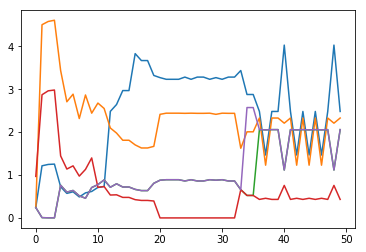

In [39]:
sns.lineplot(data = df_evolved_profits.bank2)
sns.lineplot(data = df_evolved_profits.bank10)
sns.lineplot(data = df_evolved_profits.bank3)
sns.lineplot(data = df_evolved_profits.bank1)
sns.lineplot(data = df_evolved_profits.bank4)

Part B - a)
This follows directly from the redistribution decribed above. The way this rewiring process affects the banks can be broken down in two channels:
    1. Lowering marginal cost through more connectivity
    2. Diminishing the competetive advantage of the initially well-off banks. As described in Part A, profit of a bank decreases with an increase of katz centrality of other banks.
  
I plot rolling average (at t = T, it's the average of profits from T periods) of profits following this rewiring process below (this is the most profitable bank(blue) and the least initially profitable bank(orange)):

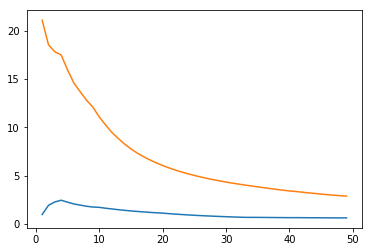

In [40]:
bank1_roll = [np.mean(df_evolved_profits.bank1[:i]) for i in range(len(df_evolved_profits.bank1))]
bank7_roll = [np.mean(df_evolved_profits.bank7[:i]) for i in range(len(df_evolved_profits.bank7))]

sns.lineplot(data = np.asarray(bank1_roll))
sns.lineplot(data = np.asarray(bank7_roll))

The above demonstrates that the rewiring (as expected) hurt the profits of the best-earning bank significantly, with profits of the two initially vastly different banks converging after 50 iterations. This is also why the lowest Katz Centrality bank may be unable to do this - the initially well of banks, knowing the consequences of engaging in this process will refuse to participate, unless they are somehow (a regulatory procedure) forced into it.

Part B - c)
We can envision the directions of links in the interbank lending market corresponding to which bank borrows money and which loans it.

As Katz centrality only concerns outgoing links, which represent access to credit and lower marginal cost, links in the other direction (unfortunately these are incoming, which makes the argument less intuitive) can be considered loans made by the bank. These are risky and I decided to include a risk measure in the model.

This would be a modified version of the Katz centrality that concerns incoming rather than outgoing links. The modification I make is that, during the rewiring proceess, our bank would look at riskiness of it's partners and, with probability (1-alpha)/2 cancel the loan access to the riskiest partner. My measure of risk is then Katz centrality with swapped directions of the links:
(perhaps a more intuitive way of explaining the idea is that I'm computing Katz Centrality of the transposed adjacency matrix)

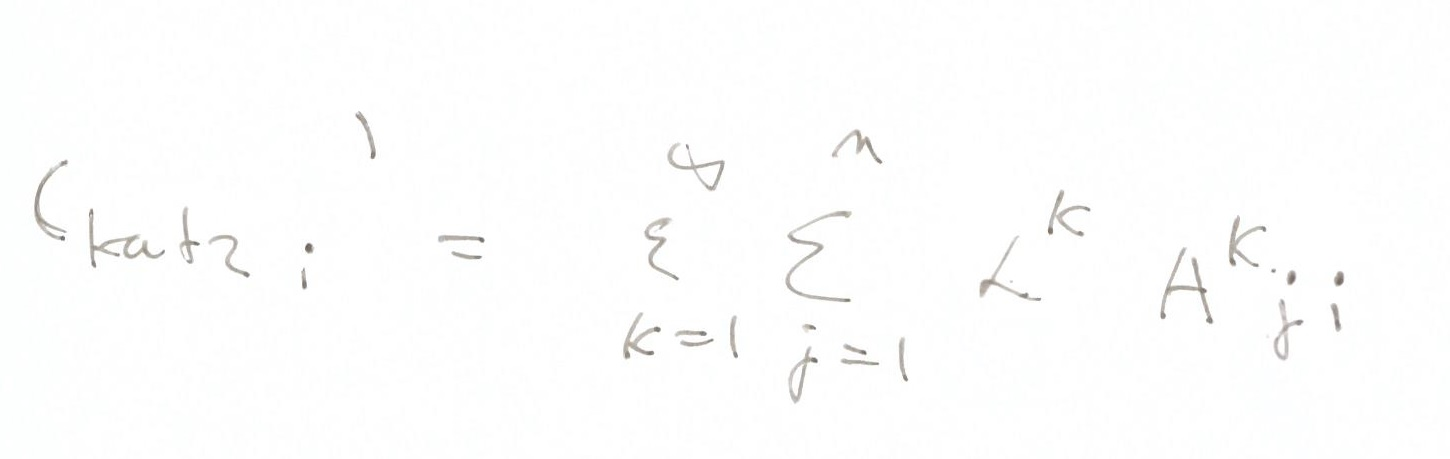

In [41]:
Image(filename=r'C:\Users\Jakub\Desktop\computational methods/risk_k.jpg')

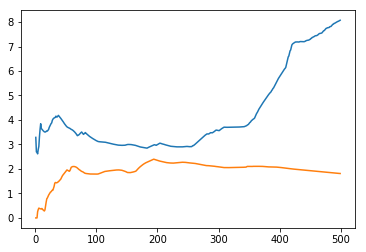

In [17]:
Image(filename=r'C:\Users\Jakub\Desktop\computational methods/risky_loans.png')

We can observe the initial convergence between profits of the most and least profitable banks, this new risk asessment rule, however arbitrarily chosen (Alpha/2 is a hyperparameter) seems to counteract the convergence from before
The above modification (where the graph comes from) is implemented in the repository linked below, in the spirit of making the notebook shorter.

The Github repository: https://github.com/mrminister/Computational-methods
- References
Junker, Shreiber (2008): Analysis of Biological Networks